# Face Generation using Pytorch Pre-trained Model

Pytorch Hub is a pre-trained model repository designed to facilitate research reproducibility. 

Using TorchNet in Analytics-Zoo, we can easily load these pre-trained model and make distributed inference with only a few lines of code change.

Here is an easy example to load Pytorch pretrained [Progressive Growing of GANs (PGAN)](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/) from Pytorch Hub to Analytics-Zoo, and generate a few faces with TorchNet. We just make a little change of the pytorch prediction example code in [PGAN](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/).

### Load pretrained model from Pytorch Hub
Load [PGAN](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/) from Pytorch Hub.
This PGAM model trained on high-quality celebrity faces "celebA" dataset, and will outputs 512 x 512 pixel images

In [1]:
import torch

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=False)

Using cache found in /home/xin/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


### Initialize Analytics-Zoo

In [2]:
from zoo.common.nncontext import init_nncontext
from zoo.pipeline.api.net.torch_net import TorchNet
import numpy as np
sc = init_nncontext("PGAN Inference Example")

### Generate noise with model's build-in method

In [3]:
num_images = 4
noise, _ = model.buildNoiseData(num_images)

### Load Generation Network to TorchNet

In [4]:
net = TorchNet.from_pytorch(model.netG, noise.numpy().shape)

/home/xin/.local/lib/python3.6/site-packages/torch/jit/__init__.py:702: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[1, 2, 290, 473] (-0.19471502304077148 vs. -0.19465310871601105) and 3742 other locations (0.00%)
  _check_trace([example_inputs], func, executor_options, traced, check_tolerance, _force_outplace)


creating: createTorchNet


### Run Generation in Local Mode
Below prediction is local mode the same with pytorch example:
```python
with torch.no_grad():
    generated_images = model.test(noise)
```

In [5]:
%%time
result = net.predict(noise.numpy())
generated_images=result.collect()

CPU times: user 10.8 ms, sys: 4.71 ms, total: 15.5 ms
Wall time: 4.94 s


### Show Image with Matplotlib and Torchvision

In [6]:
import matplotlib.pyplot as plt
import torchvision
grid = torchvision.utils.make_grid(torch.Tensor(generated_images).clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

<Figure size 640x480 with 1 Axes>

# Run Distributed Generation on Spark using TorchNet
This sector will show you how to run TorchNet on spark, and do the generation in distributed mode.

### Construct noise RDD
Use np.randam.randn to generate 64 noise data on spark.

In [7]:
dist_num_images = 64
def gen_sample(seed):
    np.random.seed(seed) # set a seed every time to avoid get the same noise data
    return Sample.from_ndarray(np.random.randn(512), np.zeros(1))

from zoo.common import Sample
noiseRdd = sc.range(0, dist_num_images).map(lambda i: gen_sample(i))

### Run Generation in Distributed Mode
Just set distributed to true, the prediction will run on Spark.
The parameter batch_per_thread means how many noise data will be processed once in a thread. The total thread number is your total spark cores.

In [8]:
%%time
dist_result = net.predict(noiseRdd, batch_per_thread=4, distributed=True)
dist_generated_images = dist_result.collect()

CPU times: user 48.8 ms, sys: 34.2 ms, total: 83 ms
Wall time: 23.6 s


### Show Image with Matplotlib and Torchvision
As ___dist_generated_images___ is a list of ndarray, we need to concate them into a single ndarray.

In [9]:
dist_generated_images = np.stack(dist_generated_images)
dist_grid = torchvision.utils.make_grid(torch.Tensor(dist_generated_images).clamp(min=-1, max=1),
                                        scale_each=True, normalize=True)

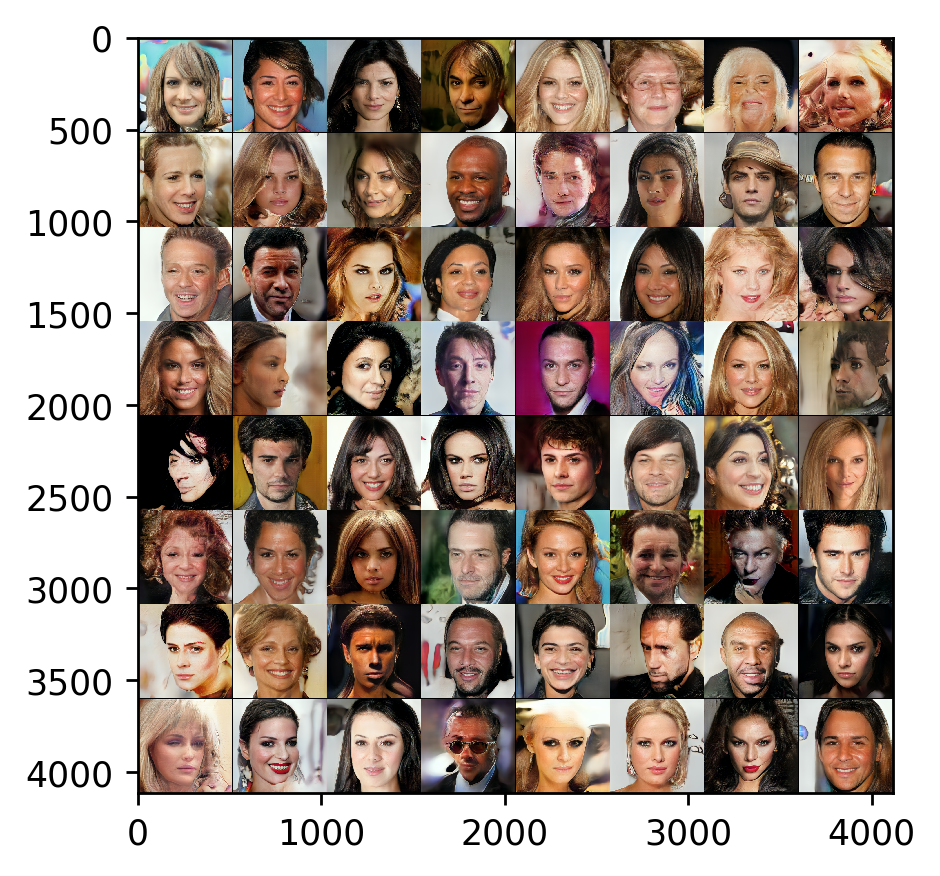

In [10]:
fig = plt.figure(dpi=250)
plt.imshow(dist_grid.permute(1, 2, 0).cpu().numpy())
plt.show()